In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch

In [2]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [3]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CSG/'

# Prepare Data

In [4]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8']
ncols = (len(regions) + 1) // 2 # plotting
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/clear_sky_generation/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds_aus = xr.Dataset(region_darrays)
ds_aus = ds_aus.load()

time_utc = pd.to_datetime(ds_aus.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds_aus = ds_aus.assign_coords(time=("time", time_aest_naive))

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [5]:
mask = (ds_aus['time'].dt.hour > 11) & (ds_aus['time'].dt.hour < 14)

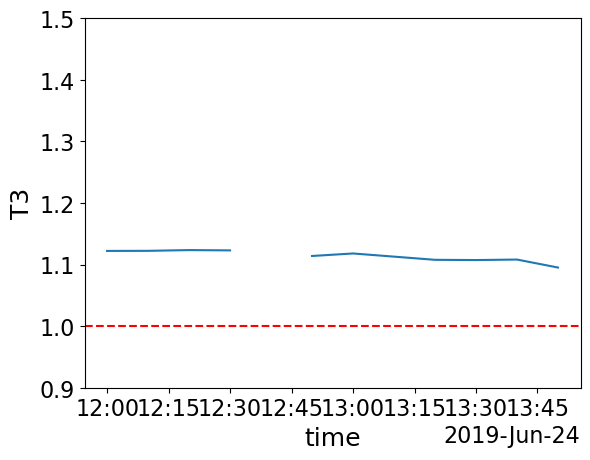

In [6]:
ds_aus['T3'][mask].sel(time='2019-06-24').plot()
plt.ylim(0.9, 1.5)
plt.axhline(1, color='r', linestyle='--')
plt.show()

In [7]:
ds_aus.T3[mask][ds_aus.Q2[mask] > 1.18]

<xarray.DataArray 'T3' (time: 5)> Size: 40B
array([0.99314218, 0.74049676, 0.70313641, 0.68245757, 0.66714609])
Coordinates:
  * time     (time) datetime64[ns] 40B 2019-08-12T12:00:00 ... 2019-08-12T13:...

In [36]:
for reg in regions:
    print(reg)
    daily = ds_aus[reg][mask].resample(time='1D').max().rolling(time=14).max()
    print(daily[daily < 0.8].time.data)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

Q2
['2019-02-07T00:00:00.000000000' '2019-02-08T00:00:00.000000000'
 '2021-01-03T00:00:00.000000000' '2021-01-04T00:00:00.000000000'
 '2021-01-05T00:00:00.000000000' '2021-01-06T00:00:00.000000000'
 '2021-01-07T00:00:00.000000000' '2021-01-08T00:00:00.000000000'
 '2021-01-09T00:00:00.000000000' '2021-01-10T00:00:00.000000000'
 '2023-01-04T00:00:00.000000000' '2023-01-05T00:00:00.000000000'
 '2023-01-06T00:00:00.000000000' '2023-01-07T00:00:00.000000000'
 '2023-01-08T00:00:00.000000000' '2023-01-09T00:00:00.000000000'
 '2023-01-10T00:00:00.000000000' '2023-01-11T00:00:00.000000000'
 '2023-01-12T00:00:00.000000000' '2023-01-13T00:00:00.000000000'
 '2023-01-14T00:00:00.000000000' '2023-01-15T00:00:00.000000000'
 '2023-01-16T00:00:00.000000000' '2023-01-17T00:00:00.000000000'
 '2023-01-18T00:00:00.000000000' '2023-02-10T00:00:00.000000000'
 '2024-01-20T00:00:00.000000000' '2024-01-21T00:00:00.000000000'
 '2024-02-26T00:00:00.000000000' '2024-02-27T00:00:00.000000000'
 '2024-02-28T00:00:00.

In [42]:
np.max(ds_aus['T3'][mask])

<xarray.DataArray 'T3' ()> Size: 8B
array(1.16618717)

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(20,20))
for i, reg in enumerate(regions):
    ax[i].plot(ds_aus[reg][mask])
    ax[i].plot(ds_aus[reg][mask].resample(time='7D').max().rolling(time=30, center=True).mean())
    ax[i].set_ylim(0.5, 1.5)
    ax[i].axhline(1, color='r', linestyle='--')
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

<Axes: >

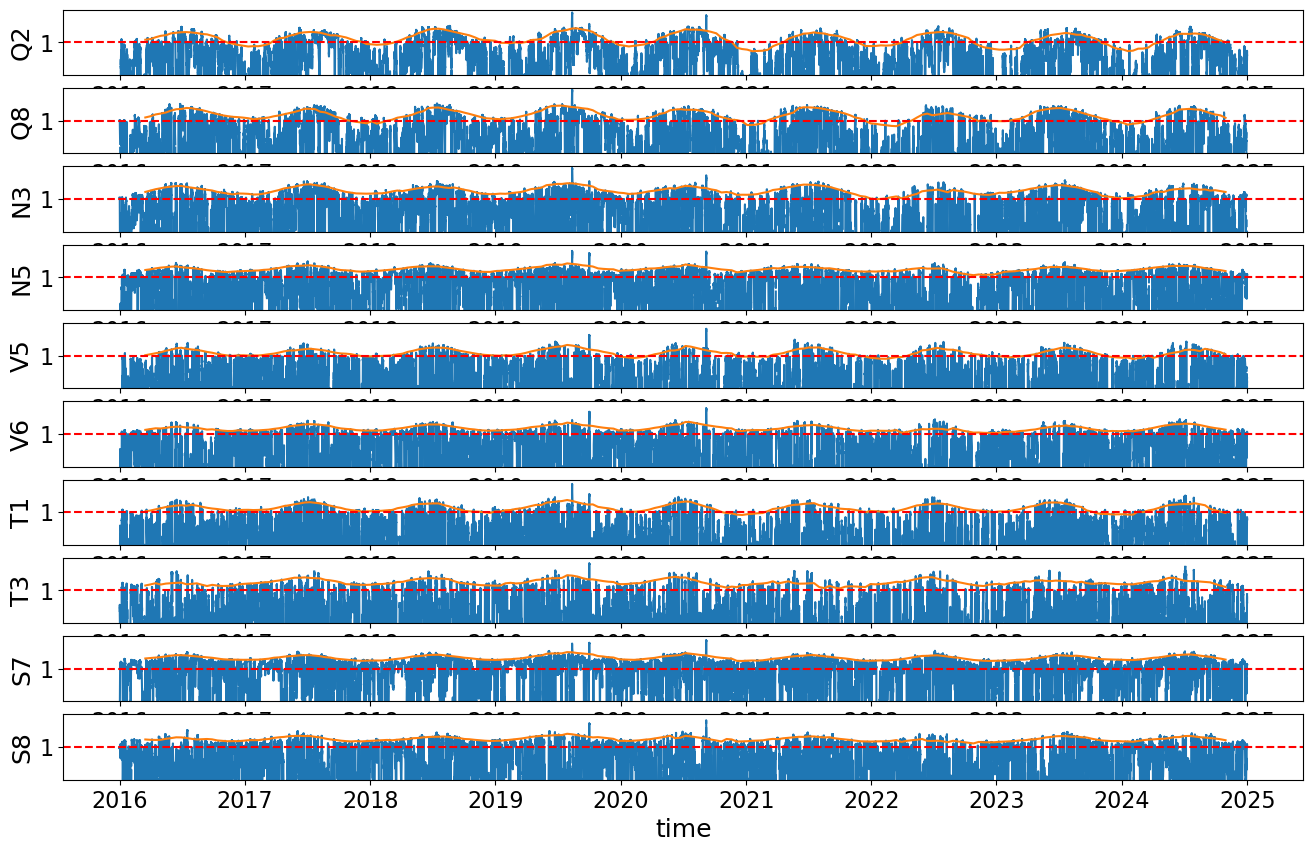

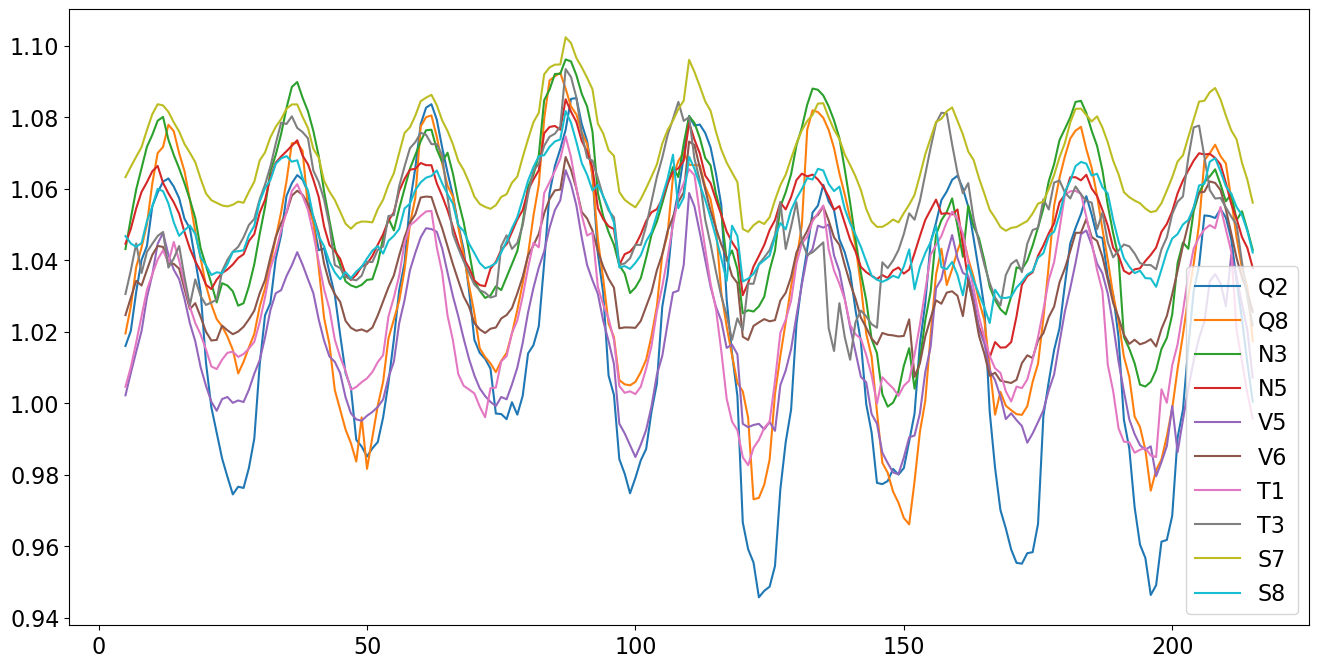

In [79]:
bias = {}
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 10))
for i, reg in enumerate(regions):
    ds_aus[reg][mask].plot(ax=ax[i])
    reg_bias = ds_aus[reg][mask].resample(time='15D').max().rolling(time=10, center=True).mean()
    reg_bias.plot(ax=ax[i])
    bias[reg] = reg_bias.values
    ax[i].set_ylim(0.8, 1.2)
    ax[i].set_yticks([1])
    ax[i].axhline(1, color='r', linestyle='--')

bias_df = pd.DataFrame(bias)
bias_df.plot(figsize=(16,8))

<Axes: >

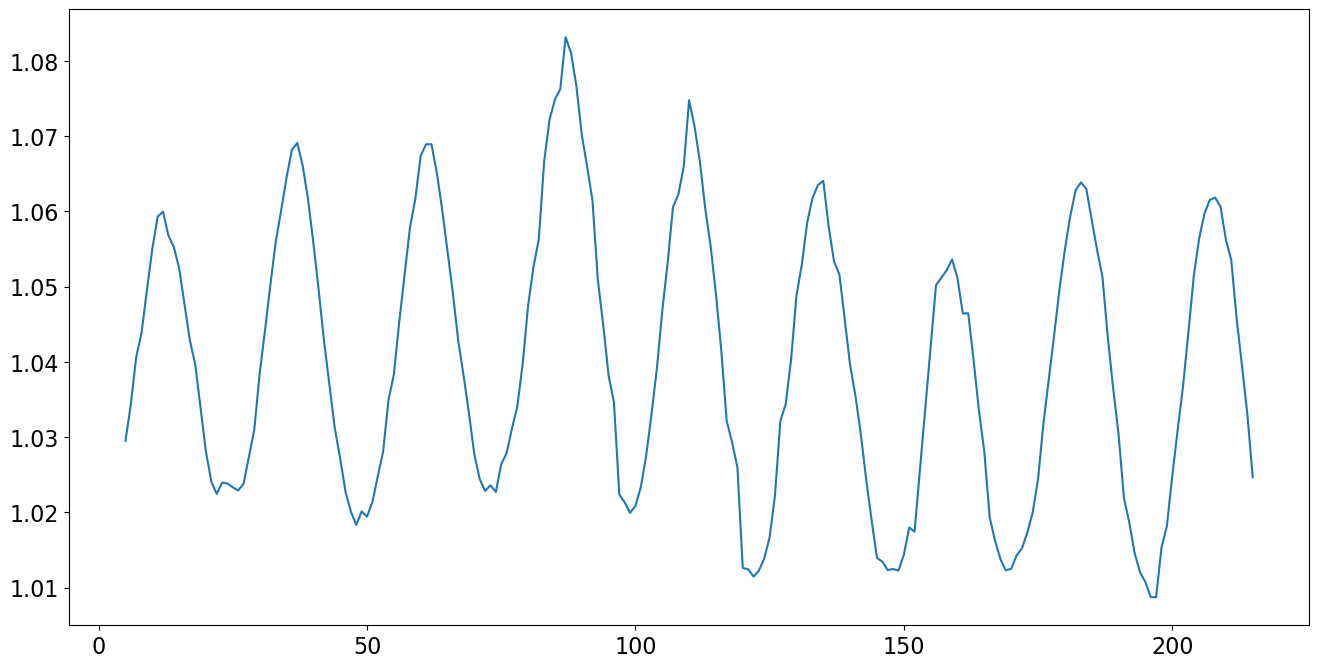

In [69]:
bias_df.mean(axis=1).plot(figsize=(16,8))

In [70]:
correction = bias_df.mean(axis=1)
correction
# for reg in region:
#     ds_aus[reg][mask]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
215    1.024672
216         NaN
217         NaN
218         NaN
219         NaN
Length: 220, dtype: float64

In [ ]:
# ds_aus = ds_aus.clip(max=1)

# Remove missing middle of the day time

In [5]:
ds_aus = ds_aus.where(ds_aus['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Clip Dusk and Dawn

In [6]:
# REMOVE BAD DUSK AND DAWN DATA
for state in regions:
    ds_aus[state] = solar_plotting.clip_dusk_dawn(ds_aus[state], n=6)

# Make a combined "total" variable to represent all regions

In [7]:
stacked = xr.concat([ds_aus[var] for var in ds_aus.data_vars], dim="region")

total = stacked.mean(dim="region")

ds_aus["total"] = total

# Constant below threshold

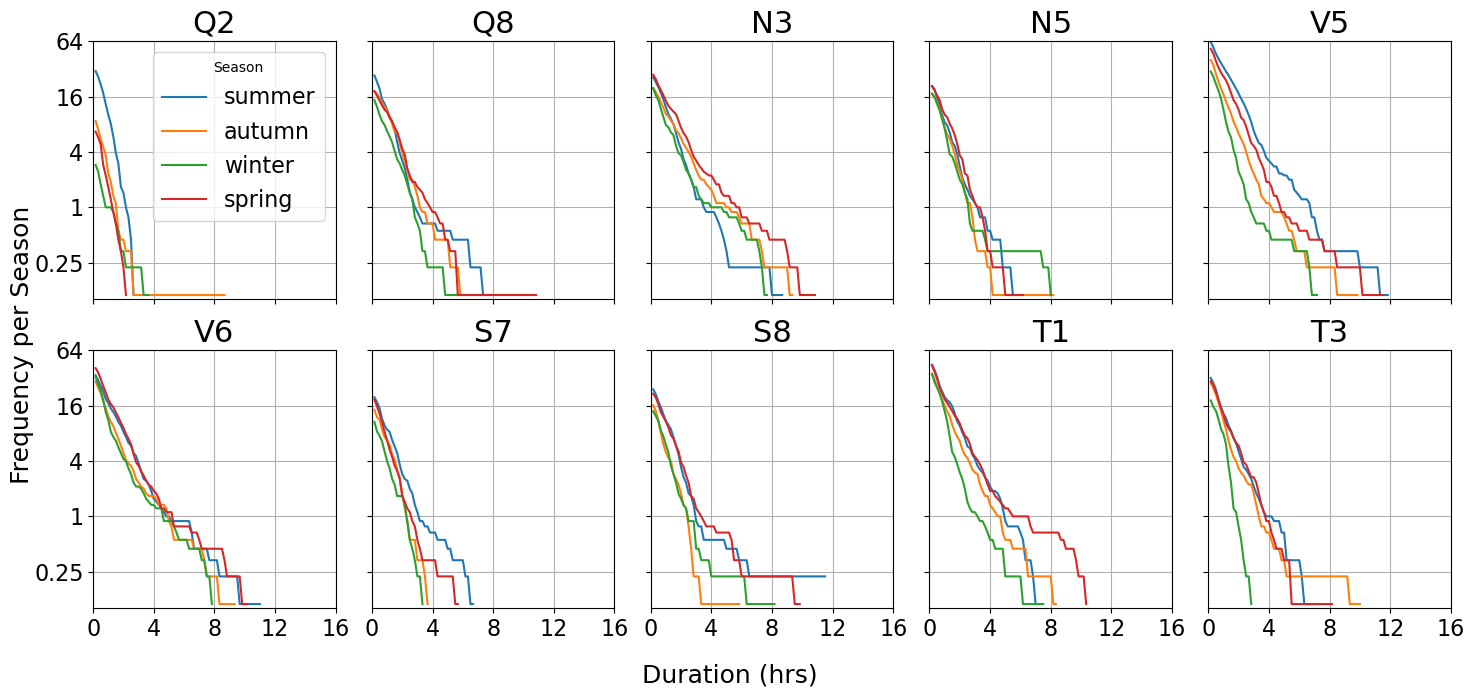

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.constant_below_threshold(da=ds_aus[reg], threshold=0.2)
    for season in cbt:
        x = np.array(cbt[season][0])
        y = np.array(cbt[season][1])
        ax[i].plot(x[y > 0], y[y > 0], label=season)
    ax[i].set_title(reg)
    ax[i].grid(True)

    # Set log scale and custom tick formatting for y-axis
    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax[0].legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

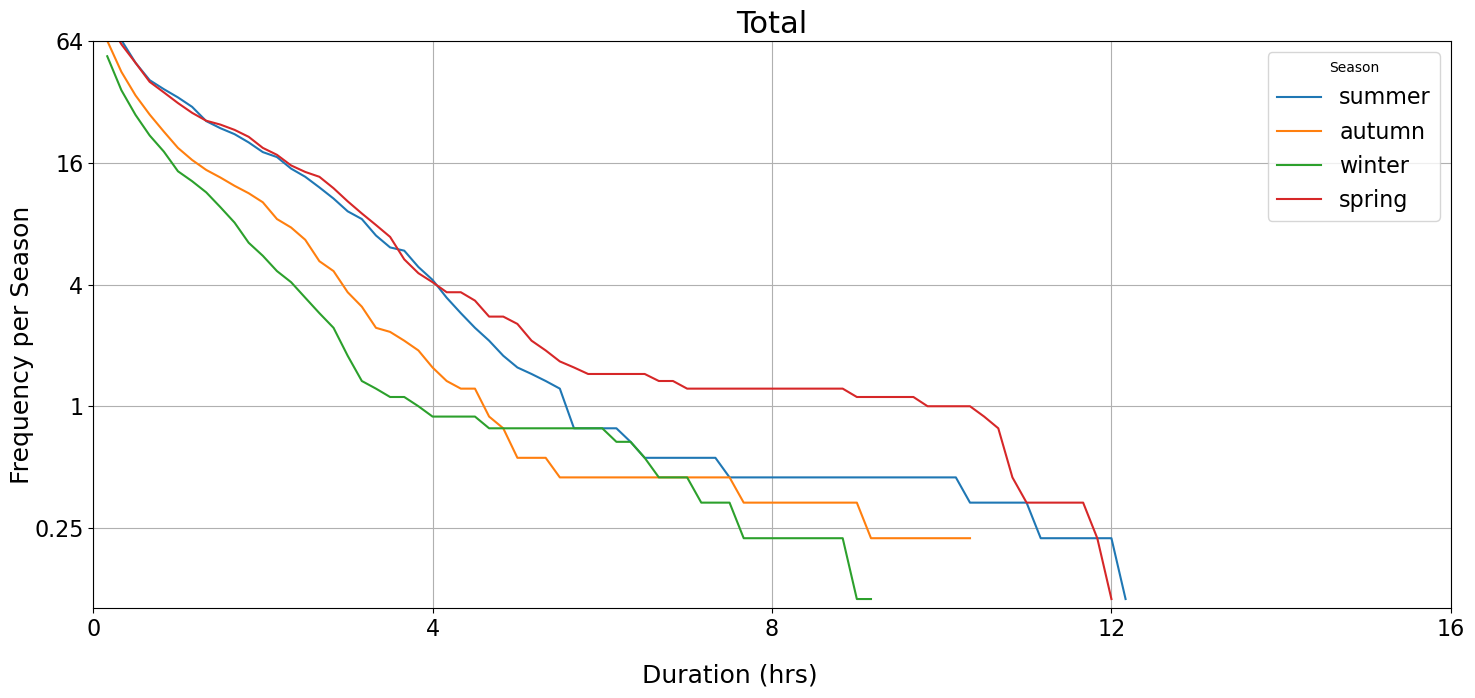

In [9]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True, sharey=True)


cbt = solar_plotting.constant_below_threshold(da=ds_aus.total, threshold=0.5)
for season in cbt:
    x = np.array(cbt[season][0])
    y = np.array(cbt[season][1])
    ax.plot(x[y > 0], y[y > 0], label=season)
ax.set_title("Total")
ax.grid(True)

# Set log scale and custom tick formatting for y-axis
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax.legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()

plt.show()

# Mean Below Threshold

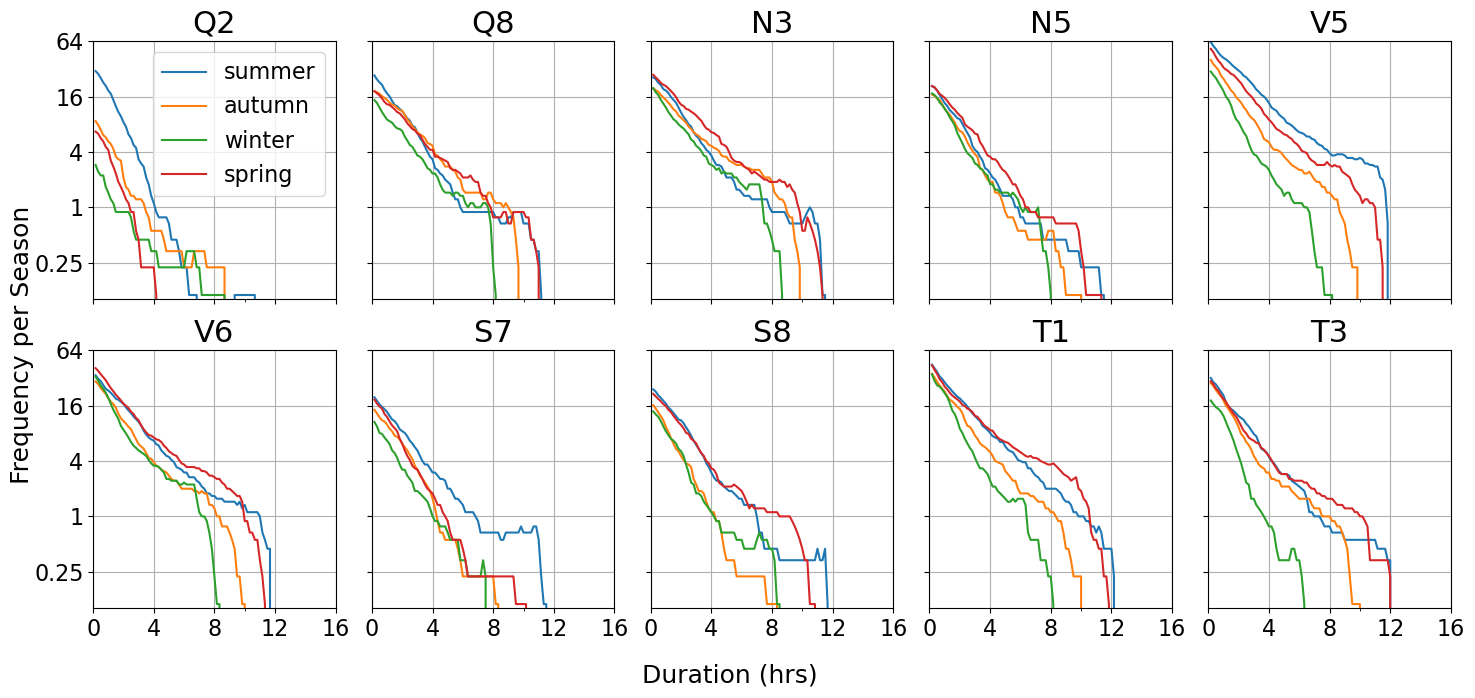

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    mbt = solar_plotting.mean_below_threshold(da=ds_aus[reg], threshold=0.2, max_hours=16)
    mbt.plot(ax=ax[i])
    ax[i].set_title(reg, rotation=0)
    ax[i].set_xlabel('')
    ax[i].legend().remove()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()


fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,16)
plt.xticks(range(0,17, 4))
plt.ylim(0.1,64)
plt.tight_layout()
plt.show()

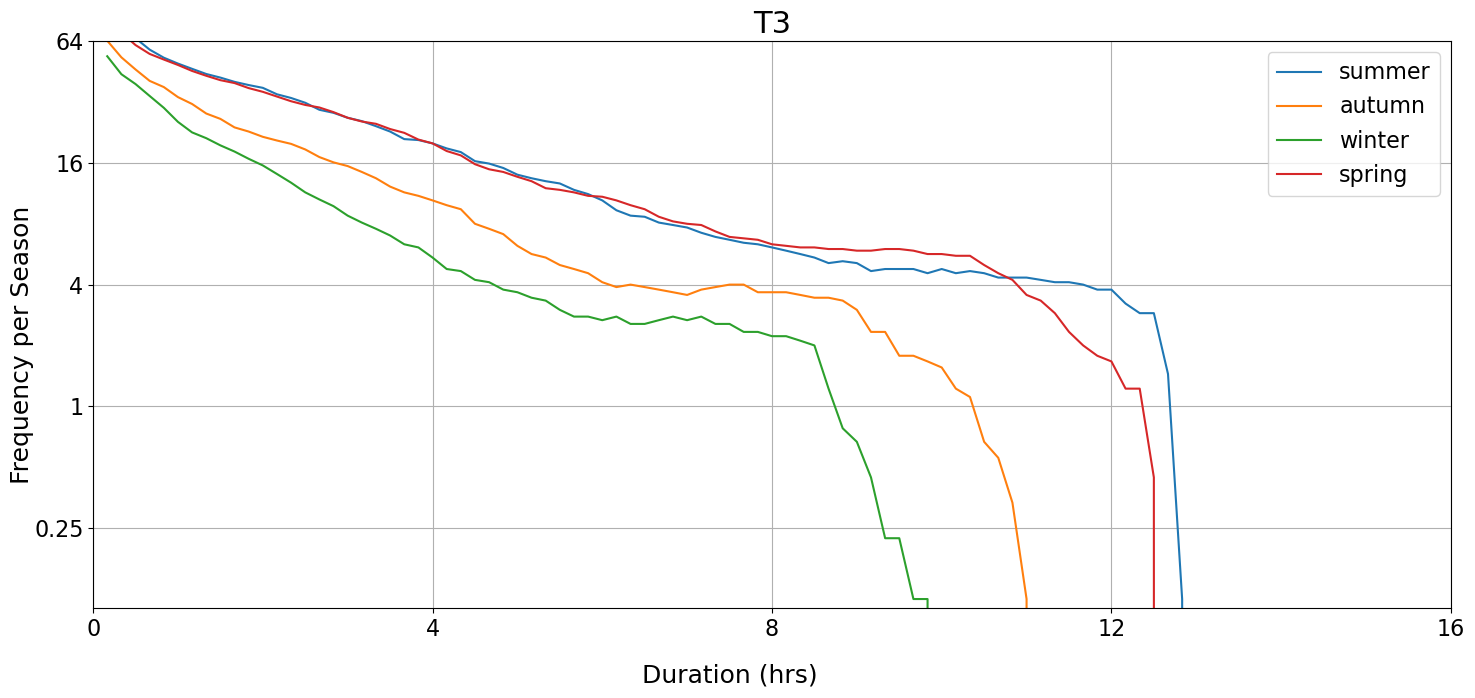

In [11]:
fig, ax = plt.subplots(figsize=(15,7), sharex=True, sharey=True)

mbt = solar_plotting.mean_below_threshold(da=ds_aus.total, threshold=0.5, max_hours=16)
mbt.plot(ax=ax)
ax.set_title(reg, rotation=0)
ax.set_xlabel('')
ax.legend().remove()
ax.grid(True)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax.axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax.legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax.legend()


fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,16)
plt.xticks(range(0,17, 4))
plt.ylim(0.1,64)
plt.tight_layout()
plt.show()

# Multi-Day Droughts

/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 v

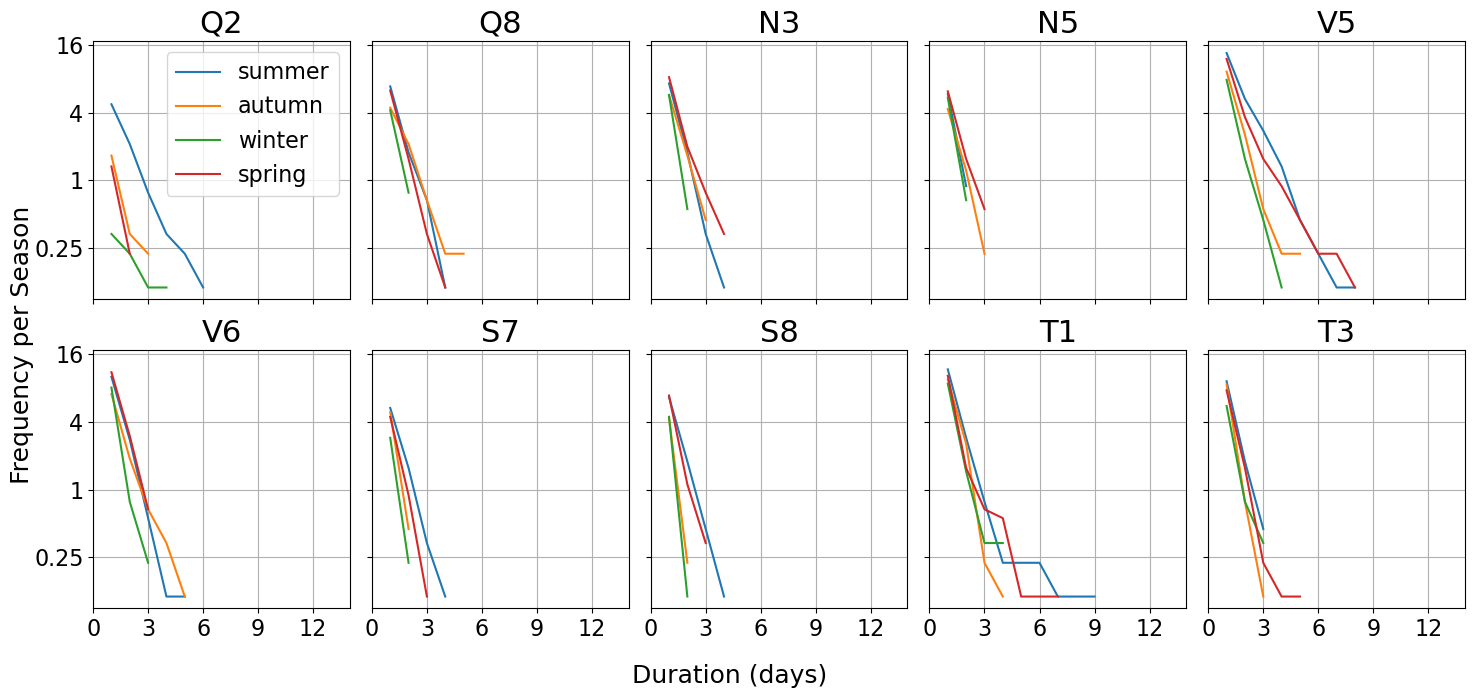

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.daily_drought(
        da=ds_aus[reg], 
        threshold = 0.2,
        tot_time=12,
        max_len=6,
        day_mean=0.2,
    )
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(reg)
    ax[0].legend()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()

fig.supxlabel('Duration (days)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,14)
plt.xticks(range(0, 14, 3))
plt.tight_layout()
plt.show()

# Day/time Heatmap

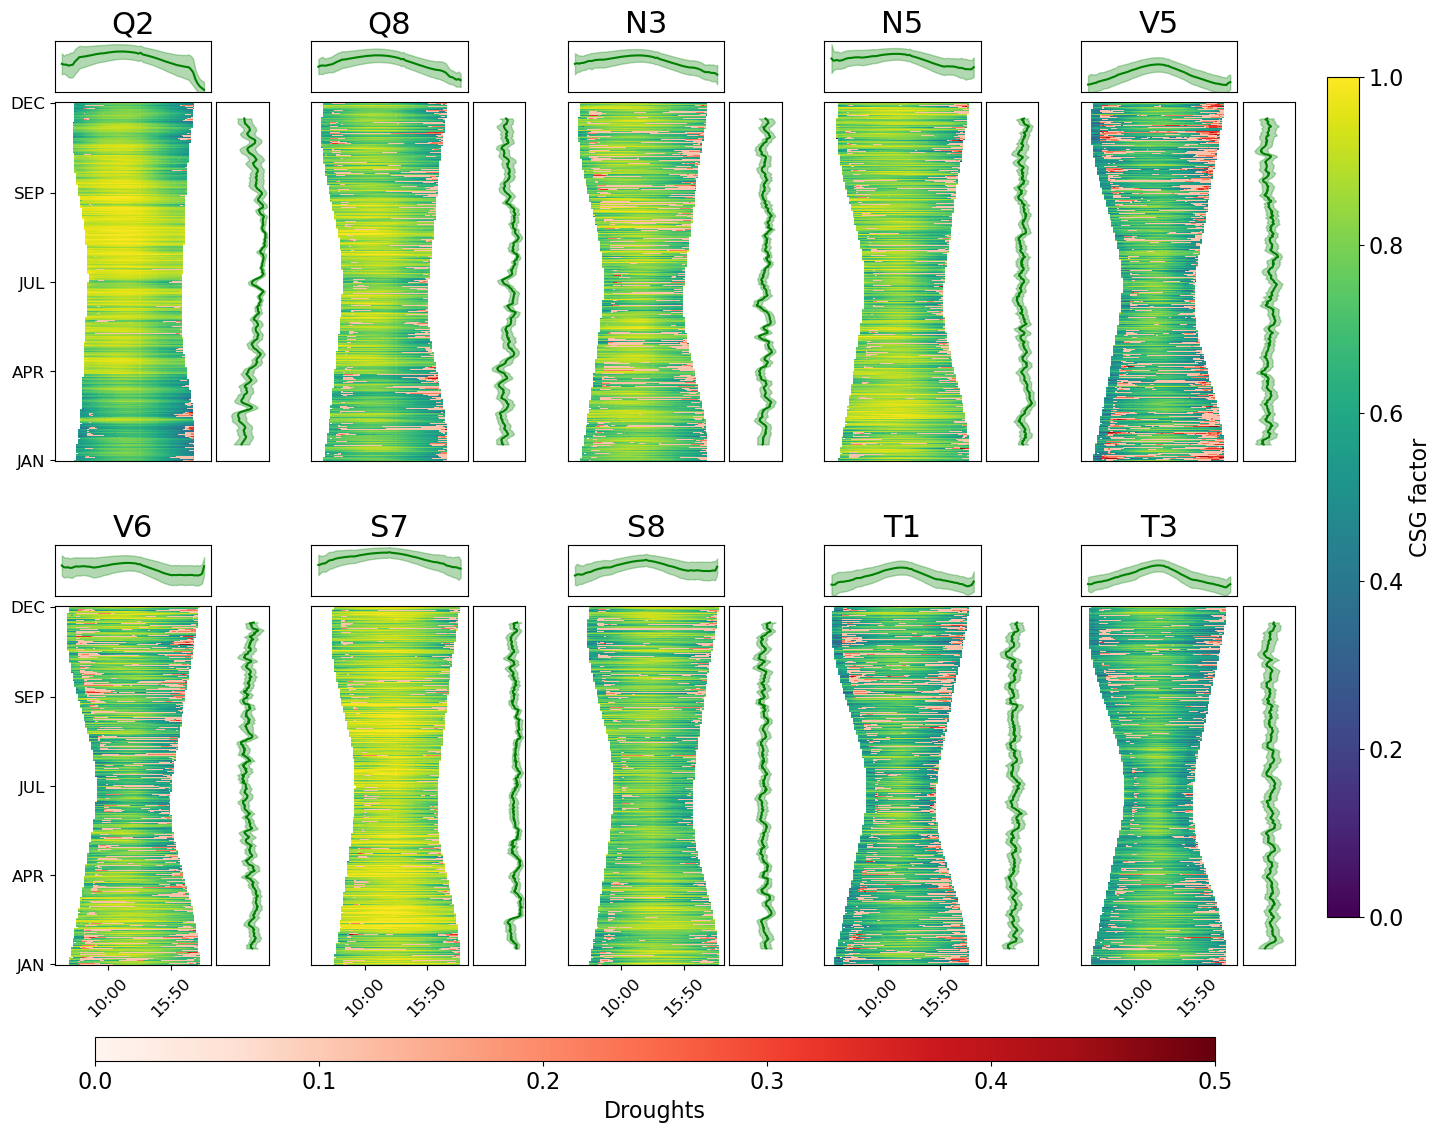

In [13]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap_droughts = plt.cm.Reds.copy()
cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')
im = None
im_droughts = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0])#, sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1])#, sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_df(ds_aus[reg])
    df = df.drop(df.columns[49], axis=1)

    df_droughts = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.2, time=6)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    alpha = np.where(np.isnan(df_droughts), 0, 1)

    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    im_droughts = ax_heatmap.imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0, vmax=0.5, interpolation='none')

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)
    if idx < 5:
        ax_heatmap.set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax_heatmap.set_yticks(yticks)
        ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax_heatmap.set_yticks([])

    ax_heatmap.set_xlim(4,89)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    
    # Plot the mean line
    line1, = ax_top.plot(mean_daily.values, color="green", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="green", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_xticks([])
    ax_top.set_ylim(0.4,1)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="green", label='Mean (annual)')
    # Shade ±1 std dev horizontally
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="green", 
        alpha=0.3, 
        label='±1 Std Dev'
    )

    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right.set_xlim(0.25, 1)

fig.colorbar(im, cax=cbar_ax).set_label('CSG factor', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('Droughts', fontsize=16)
fig_path = f'{fig_dir}/heatmap'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(f'{fig_path}/CSG-day-time-avail.png')
plt.show()

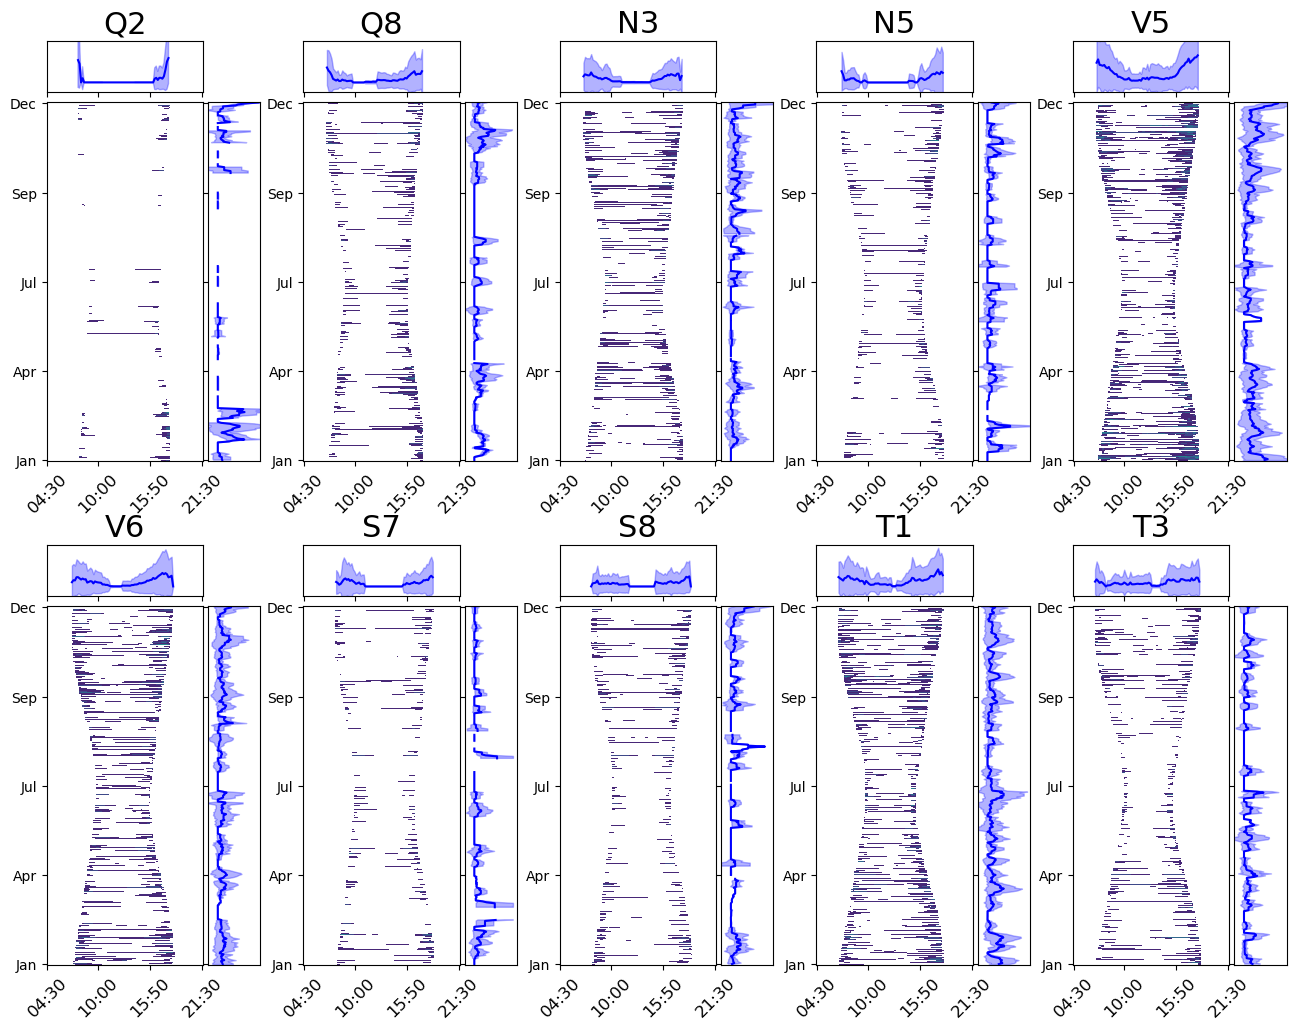

In [14]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0], sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1], sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.2, time=6)
    df = df.drop(df.columns[49], axis=1)
    df[df == 0] = np.nan

    # Heatmap
    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
    ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
    ax_heatmap.set_yticks(yticks)
    ax_heatmap.set_yticklabels(ytick_labels, fontsize=10)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    line1, = ax_top.plot(mean_daily.values, color="blue", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_ylim(0.08,0.25)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="blue", label='Mean (annual)')
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_xlim(0.08, 0.25)

fig.colorbar(im, cax=cbar_ax).set_label('Solar Irradiance (normalized)', fontsize=12)
plt.show()

# Day/Year Heatmap

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

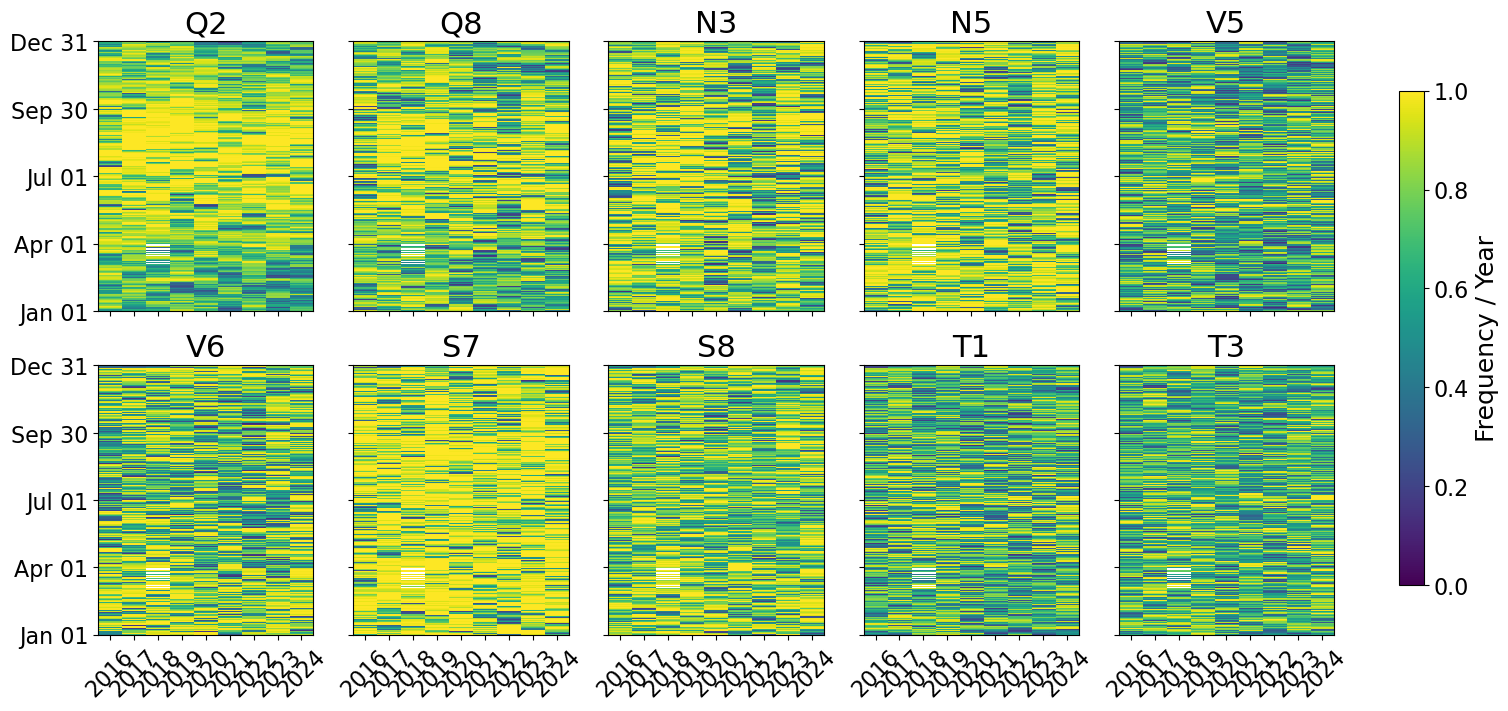

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
ax = ax.flatten()
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None
for i, reg in enumerate(regions):
    df = solar_plotting.day_year_df(daily[reg])

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')
    im = ax[i].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax[i].set_title(reg)
    xticks = np.arange(len(df.columns))
    xtick_labels = df.columns.astype(str)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    
    # Y-axis (Convert Day of Year → Month-Day)
    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
    ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
    ax[i].set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

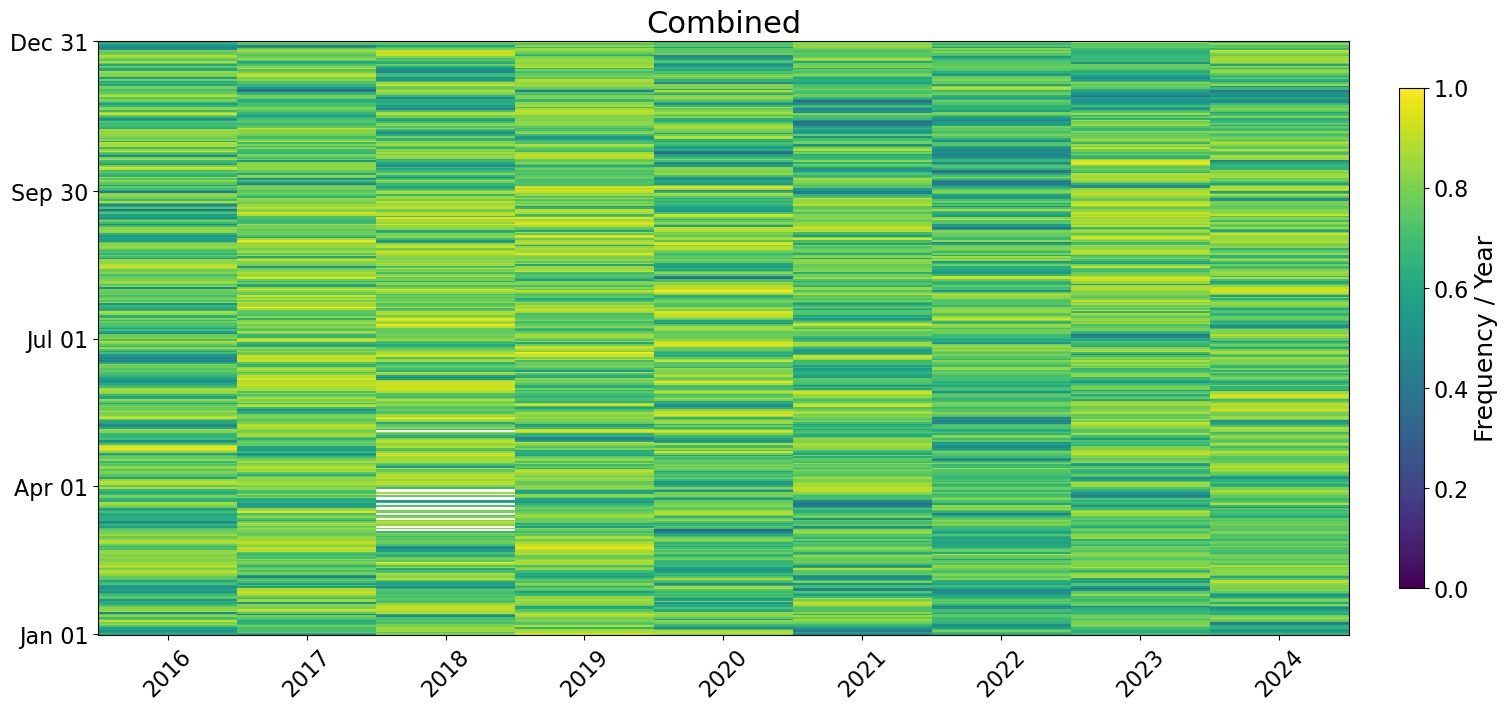

In [16]:
fig, ax = plt.subplots(figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

df = solar_plotting.day_year_df(daily.total)

cmap = plt.cm.viridis
cmap.set_bad(color='white')
im = ax.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
ax.set_title("Combined")
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Y-axis (Convert Day of Year → Month-Day)
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
ax.set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

# Coincident Droughts

In [17]:
coincident_droughts = np.zeros(len(ds_aus.time))
for reg in regions:
    drought_data = xr.where(ds_aus[reg] < 0.2, 1, 0).values
    coincident_droughts += drought_data
coincident_da = xr.DataArray(coincident_droughts, dims=ds_aus.dims, coords=ds_aus.coords)

daily = ds_aus.resample(time="1D").mean()
coincident_droughts_daily = np.zeros(len(daily.time))
for reg in regions:
    drought_data = xr.where(daily[reg] < 0.2, 1, 0).values
    coincident_droughts_daily += drought_data
coincident_da_daily = xr.DataArray(coincident_droughts_daily, dims=daily.dims, coords=daily.coords)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

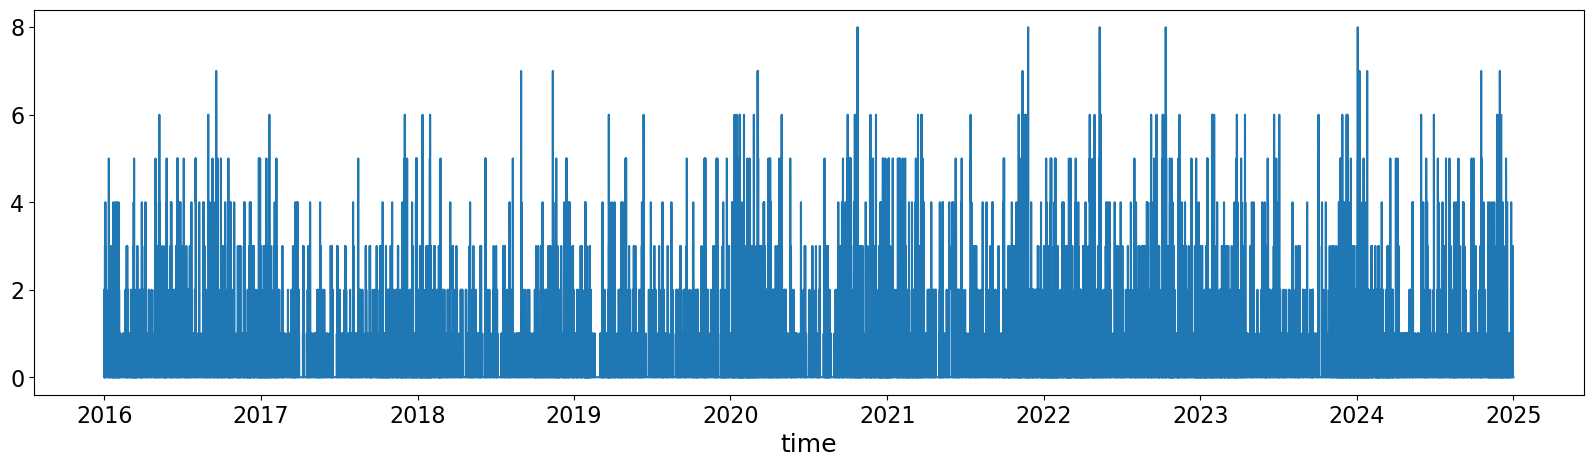

In [18]:
coincident_da.plot(figsize=(20,5))

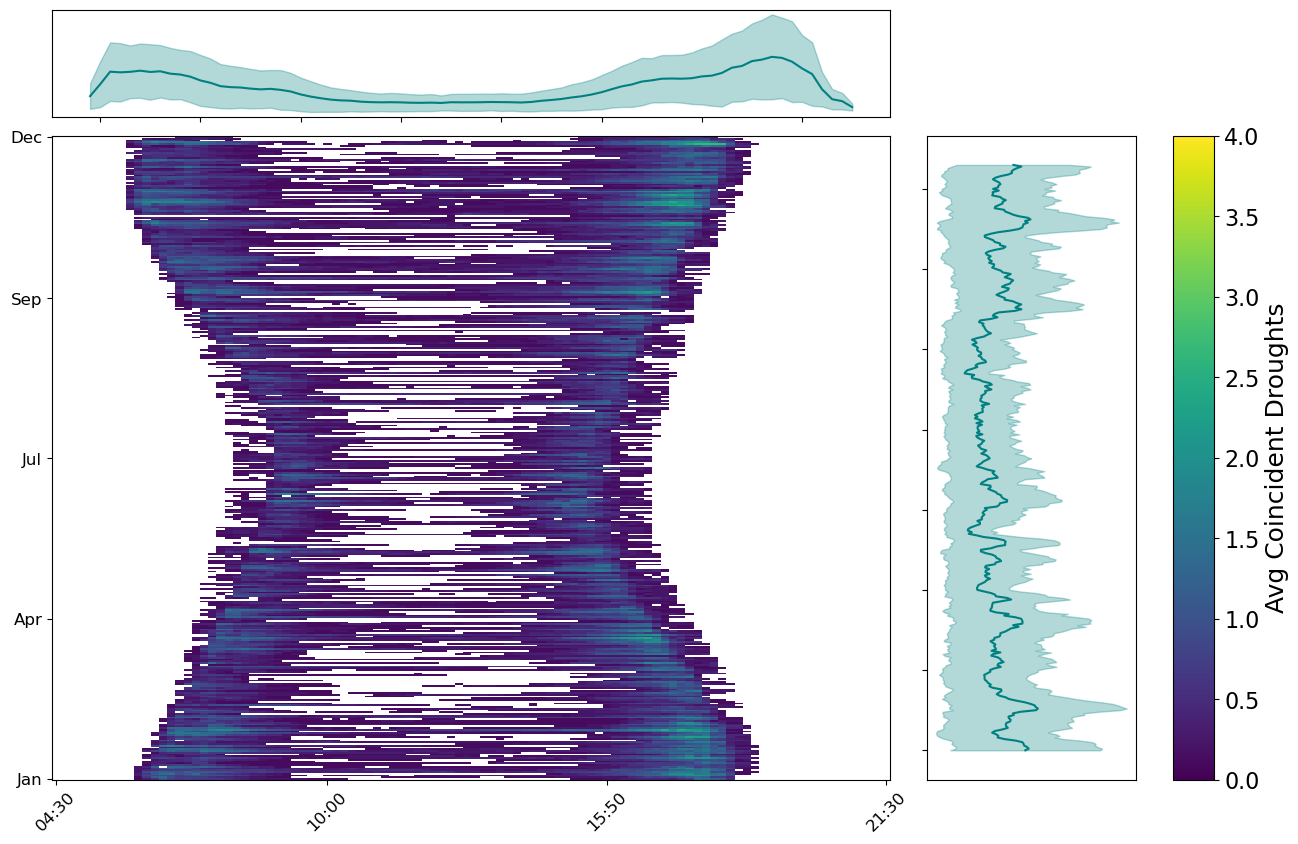

In [19]:
# Prepare data
df = solar_plotting.day_time_df(coincident_da)
df = df.drop(df.columns[49], axis=1)
df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# Axis ticks - x
xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

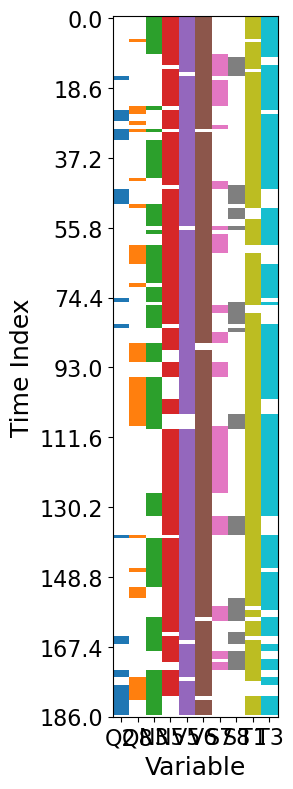

In [20]:
coincident_drought_ds = ds_aus < 0.2
times = coincident_da[coincident_da == 6].time.data

data = {}
for reg in regions:
    data[reg] = coincident_drought_ds[reg].sel(time=times).data.astype(int)
df = pd.DataFrame(data, index=times)

colors = plt.cm.tab10(np.linspace(0, 1, len(df.columns)))[:, :3]  # one color per var
rgb_img = np.ones((len(df), len(df.columns), 3))  # start all white

# Fill where value == 1
for i, col in enumerate(df.columns):
    active = df[col].values == 1
    rgb_img[active, i, :] = colors[i]

# Plot
fig, ax = plt.subplots(figsize=(3, 8))
ax.imshow(rgb_img, aspect='auto', interpolation='nearest')

# Axes: time (x), variable (y)
ax.set_xticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns)
ax.set_yticks(np.linspace(0, len(df), 11))
ax.set_ylabel("Time Index")
ax.set_xlabel("Variable")
plt.tight_layout()
plt.show()

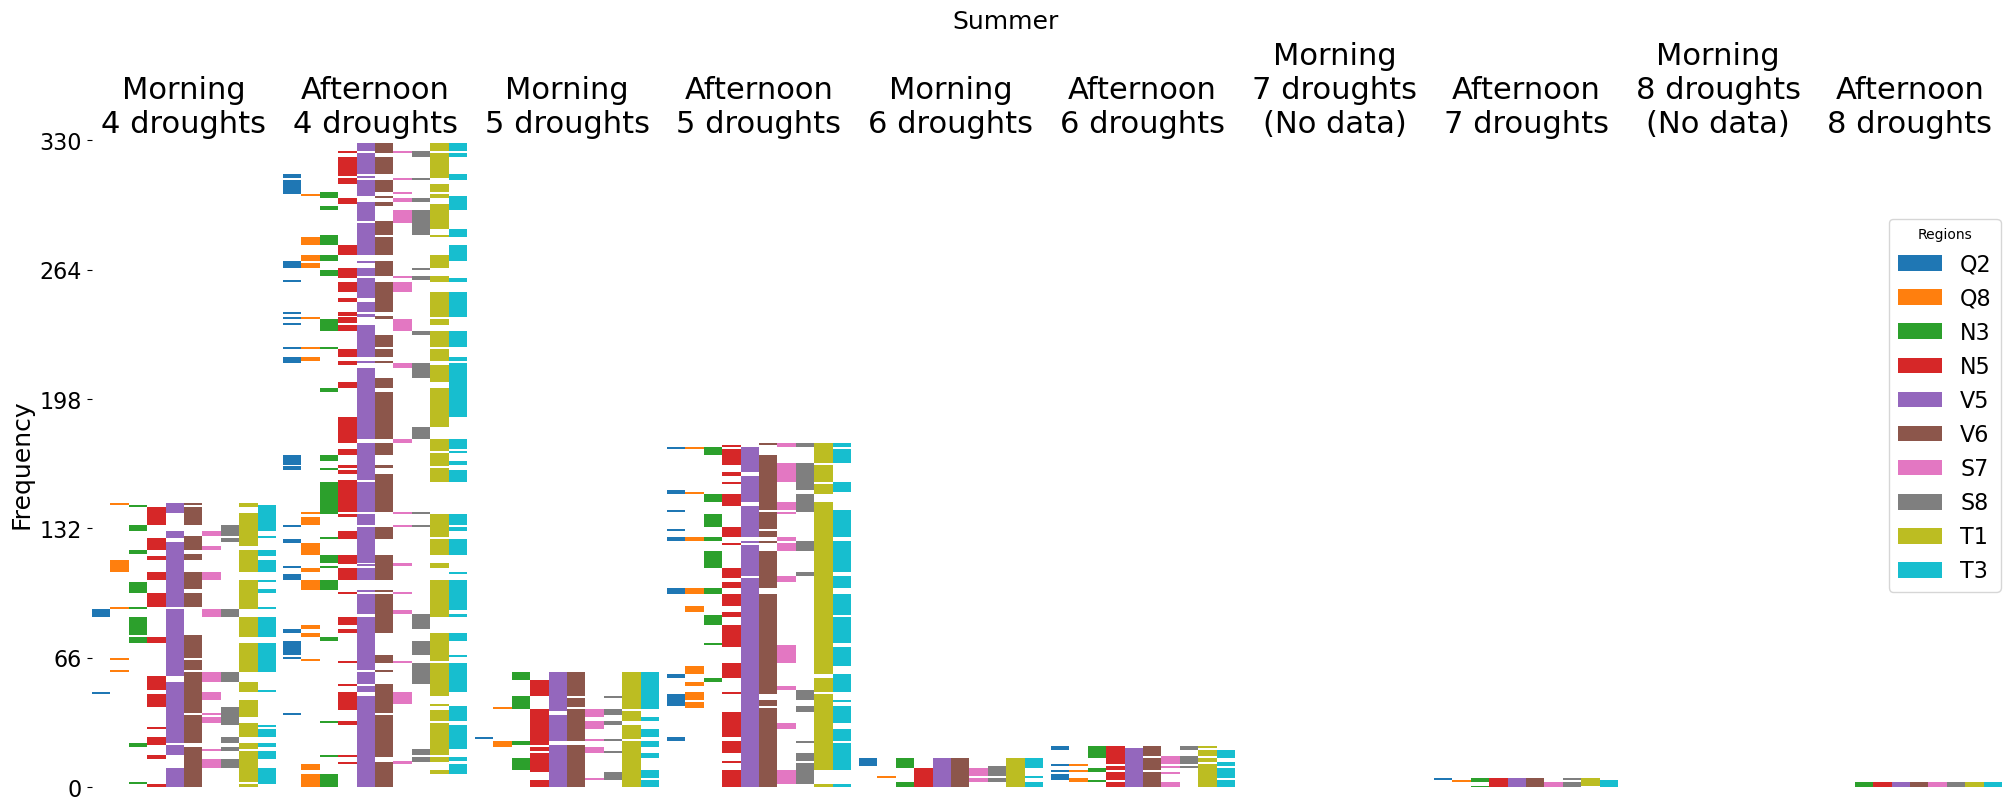

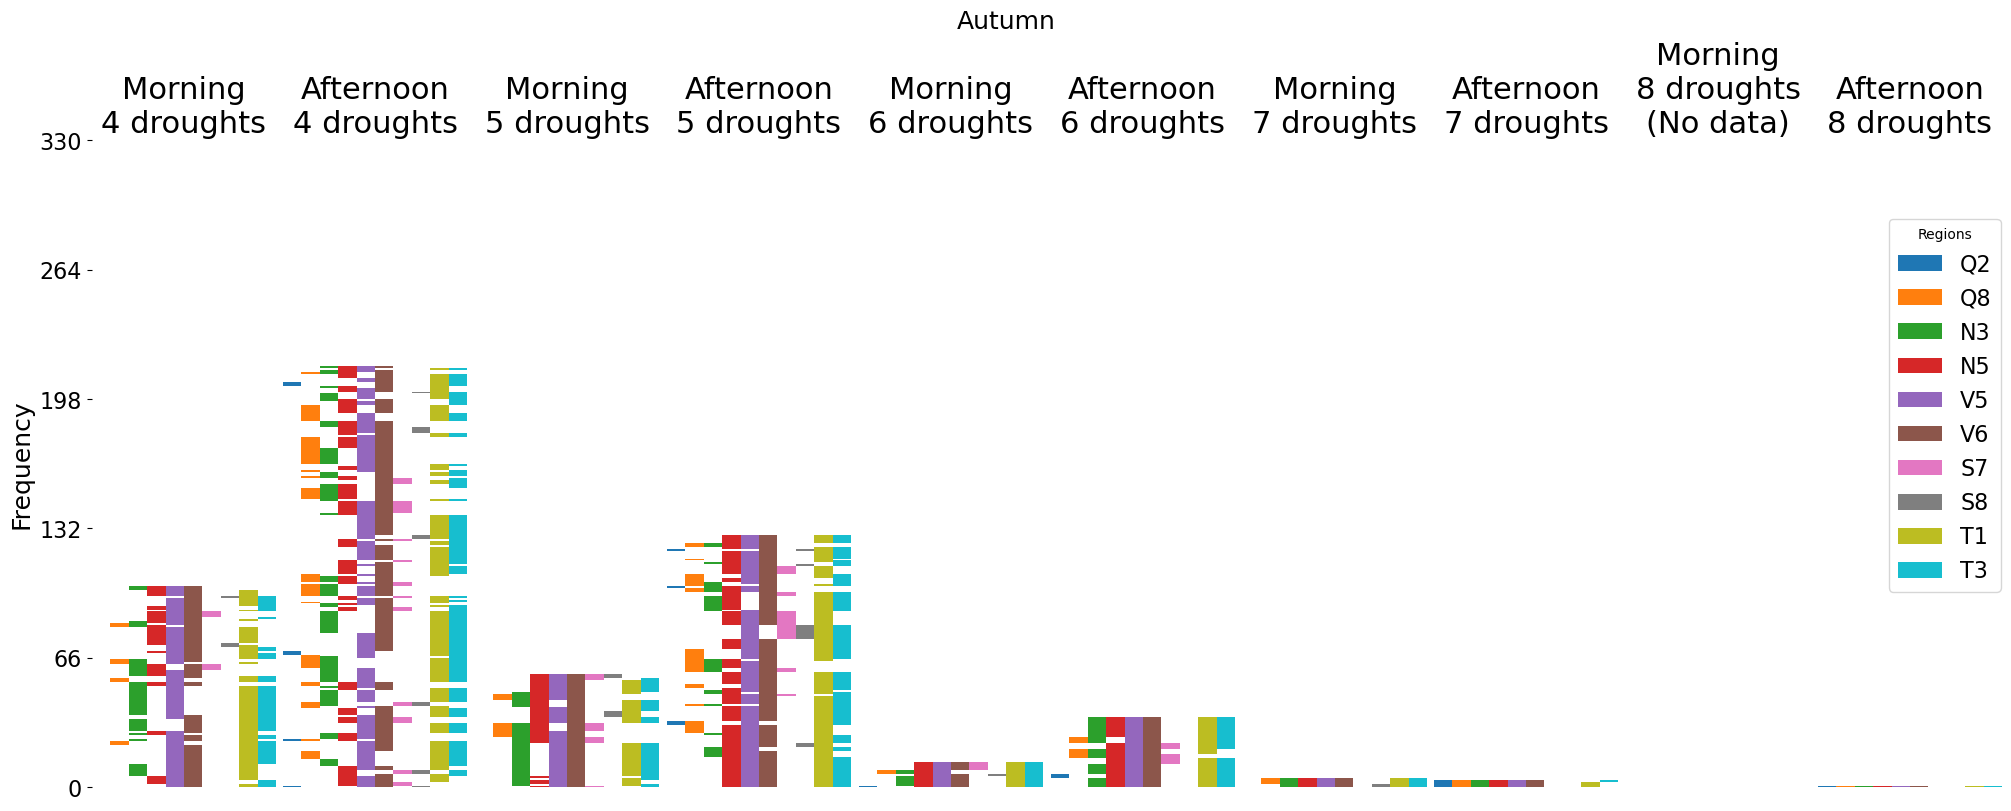

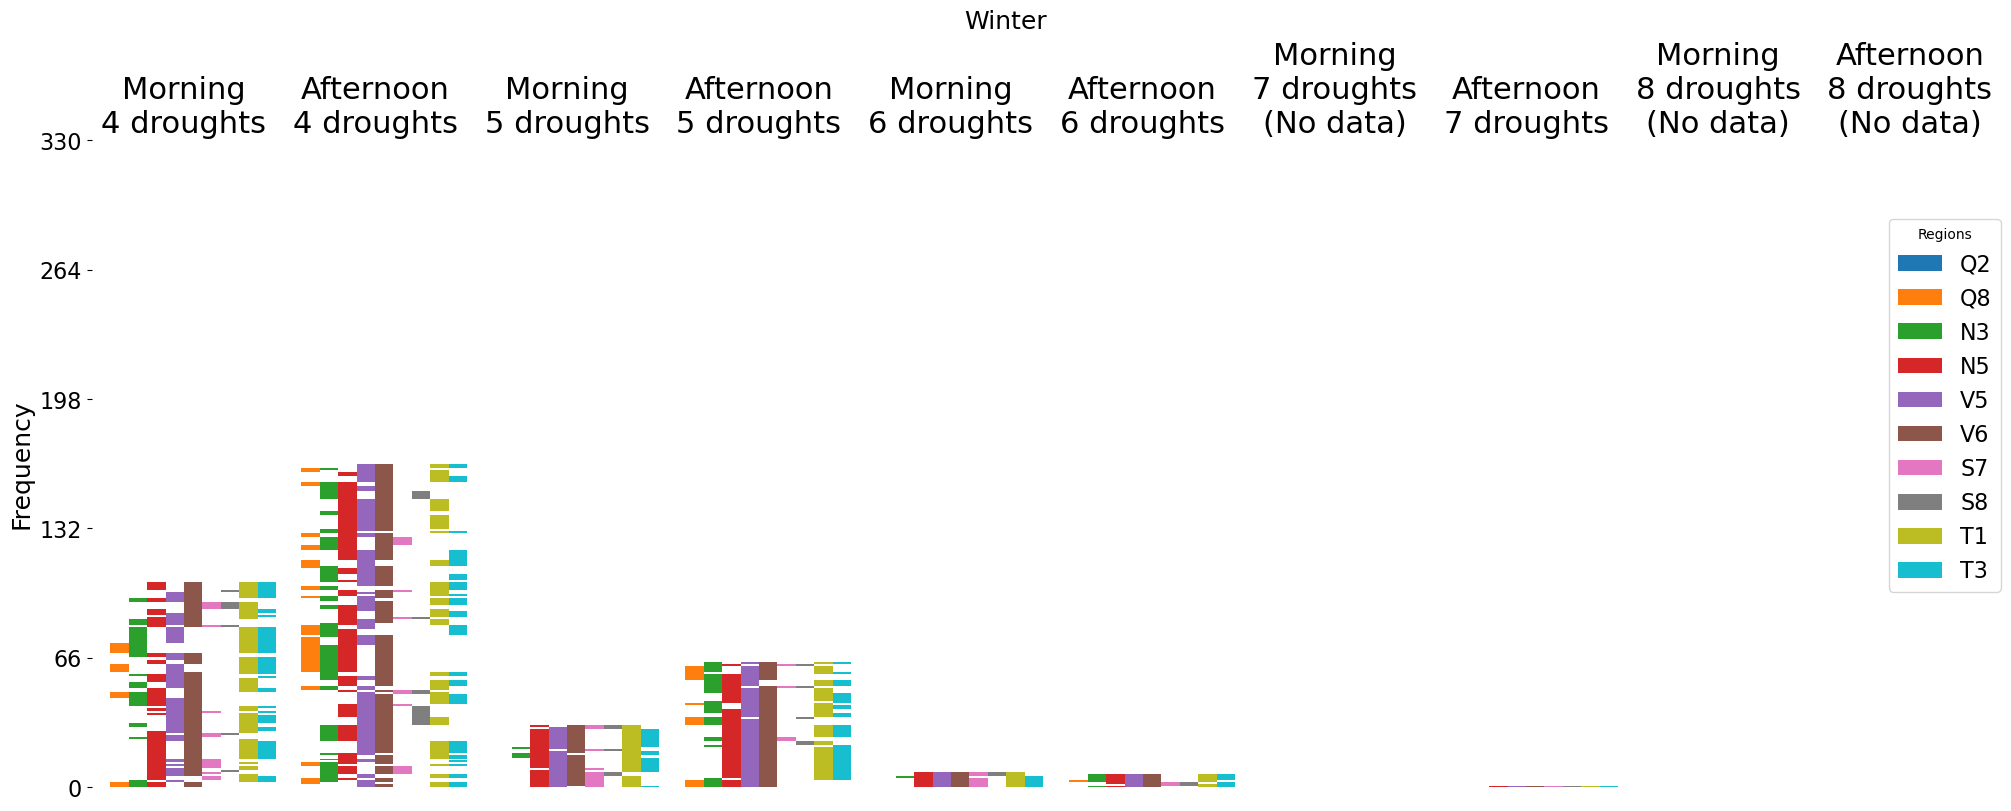

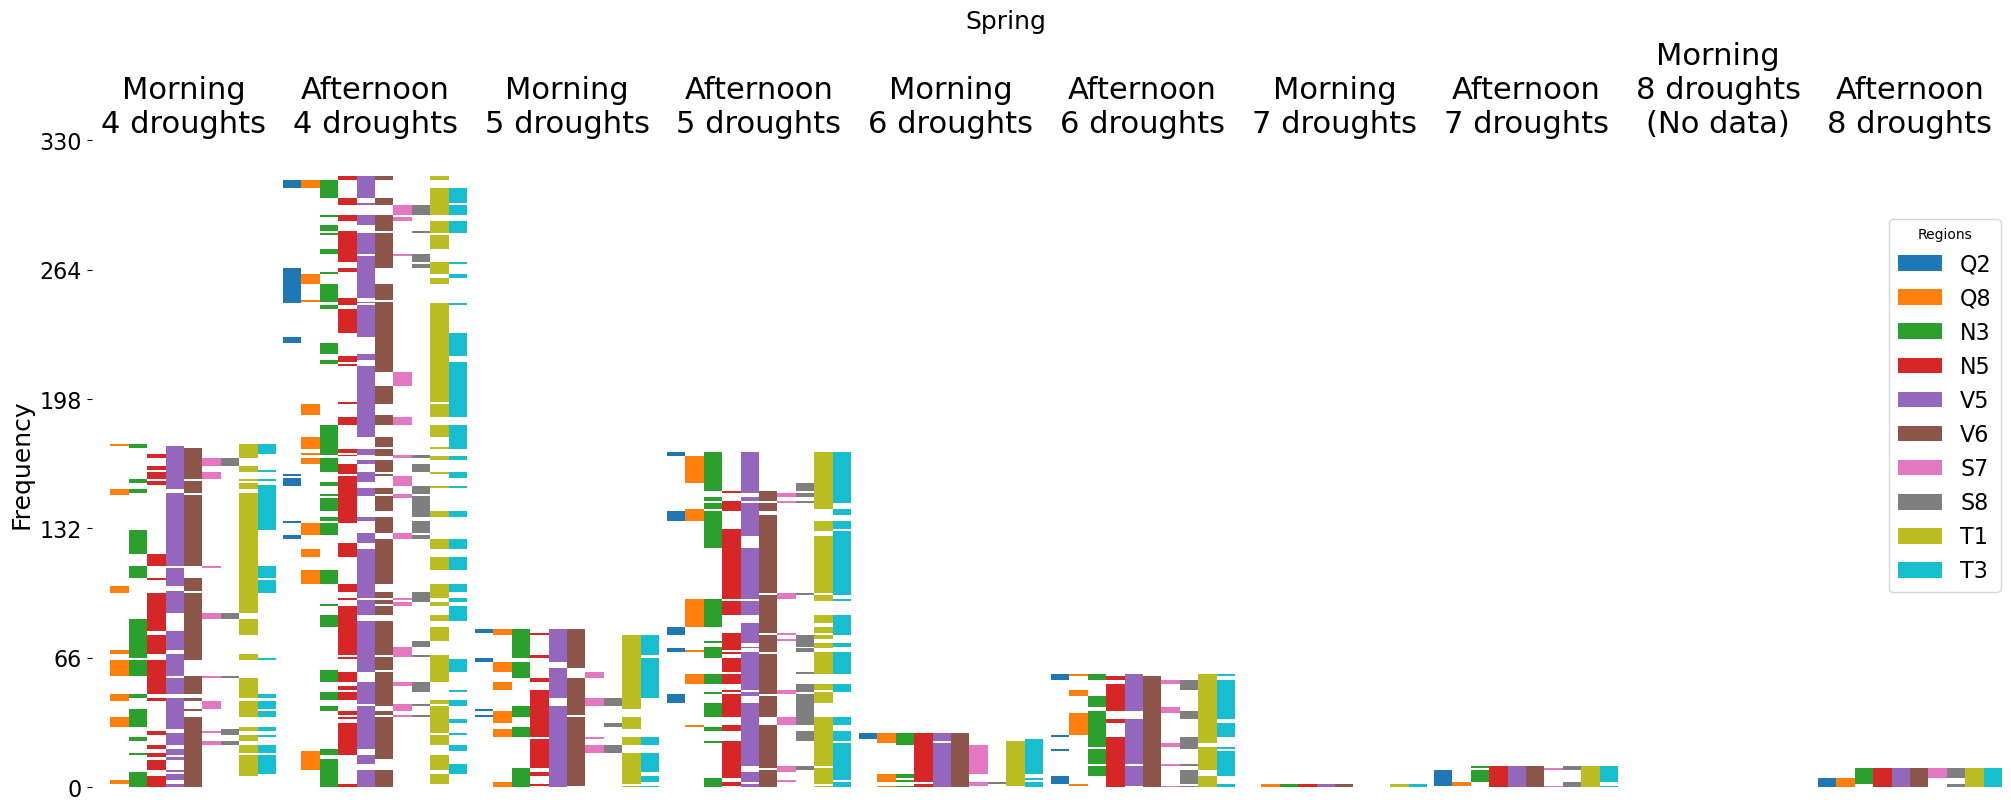

In [21]:
from matplotlib.patches import Patch

seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

for season in seasons:
    seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True)
    morning_data = seasonal_data.where(seasonal_data.time.dt.hour < 12, drop=True)
    afternoon_data = seasonal_data.where(seasonal_data.time.dt.hour >= 12, drop=True)

    fig, axes = plt.subplots(
        nrows=1, ncols=10, figsize=(20, 8),
        constrained_layout=True
    )

    all_regions = list(regions)  # ensure legend includes all
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_regions)))[:, :3]

    i = 0
    for num_droughts in range(4, 9):
        for tod_label, time_of_day in zip(["Morning", "Afternoon"], [morning_data, afternoon_data]):
            times = time_of_day[time_of_day == num_droughts].time.data

            if len(times) == 0:
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title(f"{tod_label}\n{num_droughts} droughts\n(No data)")
                for spine in axes[i].spines.values():
                    spine.set_visible(False)
                i += 1
                continue

            # Build DataFrame
            data = {
                reg: coincident_drought_ds[reg].sel(time=times).data.astype(int)
                for reg in all_regions
            }
            df = pd.DataFrame(data, index=times)

            rgb_img = np.ones((len(df), len(df.columns), 3))
            for j, col in enumerate(df.columns):
                rgb_img[df[col].values == 1, j, :] = colors[j]

            axes[i].imshow(rgb_img, aspect='auto', interpolation='none')
            axes[i].set_title(f"{tod_label}\n{num_droughts} droughts")
            axes[i].set_xticks([])
            axes[i].set_xticklabels([])
            axes[i].set_yticks([])
            axes[0].set_yticks(np.linspace(0, 330, 6, dtype=int))
            axes[0].set_ylabel("Frequency")
            axes[i].set_ylim(0, 330)
            for spine in axes[i].spines.values():
                spine.set_visible(False)

            i += 1

    # Legend
    legend_elements = [Patch(facecolor=colors[j], label=reg) for j, reg in enumerate(all_regions)]
    fig.legend(handles=legend_elements, loc='center right', title='Regions')

    fig.suptitle(f"{season.capitalize()}", fontsize=18)
    plt.show()

In [49]:
import xarray as xr

def regional_correlations(ds):
    # Stack each variable into a new 'variable' dimension
    data = xr.concat(
        [ds[var].expand_dims(variable=[var]) for var in ds.data_vars],
        dim='variable'
    )
    data = data.dropna(dim='time', how='any')
    data = data.transpose('variable', 'time')  # shape: (variable, time)
    
    # Compute pairwise correlations
    var_names = data['variable'].values
    n = len(var_names)

    corr = np.empty((n, n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            corr[i, j] = xr.corr(data.sel(variable=var_names[i]),
                                 data.sel(variable=var_names[j]),
                                 dim='time').item()

    return pd.DataFrame(corr, index=var_names, columns=var_names)

In [65]:
corr_df = regional_correlations(ds_aus).iloc[:-1,:-1]

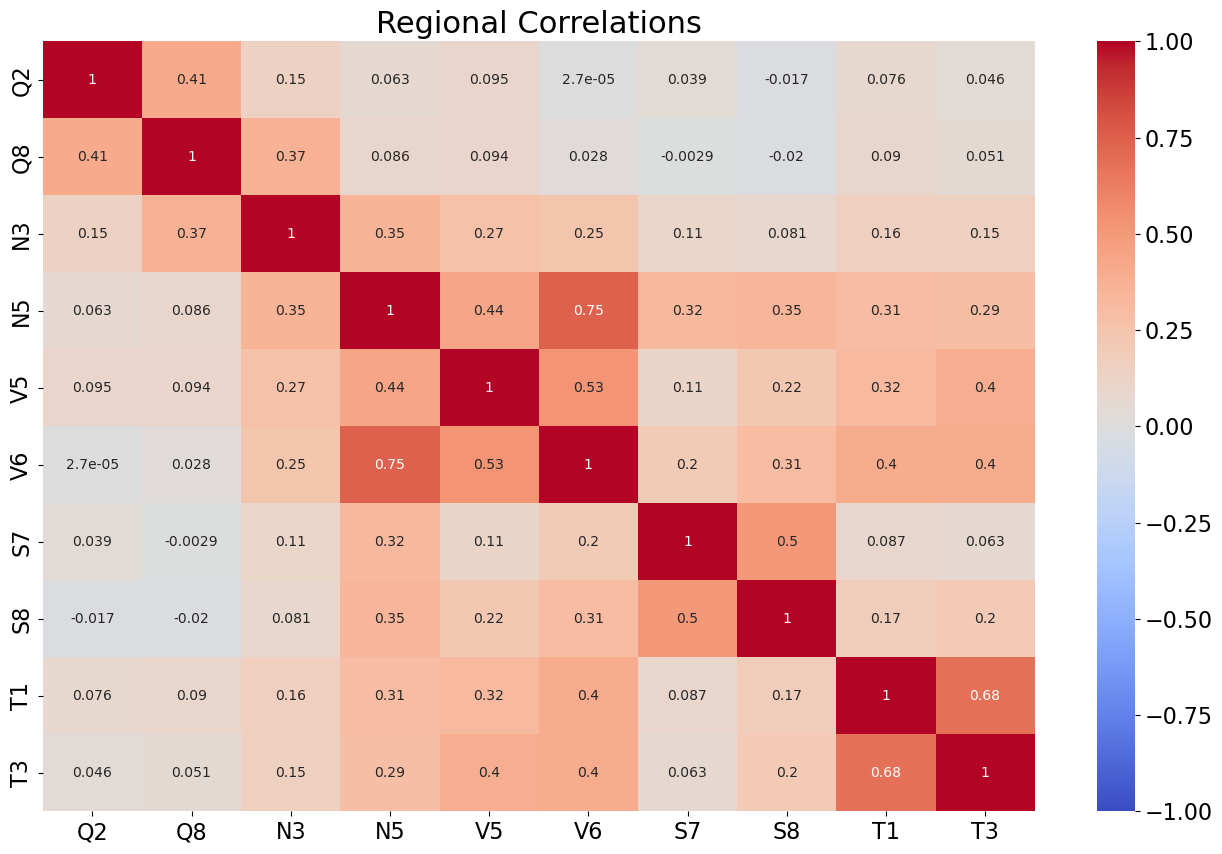

In [76]:
plt.figure(figsize=(16,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Regional Correlations')
plt.show()

In [73]:
coincident_dict = {}
for reg in regions:
    coincident_dict[reg] = []
    for second_reg in regions:
        total = sum(xr.where(ds_aus[reg] < 0.2, 1, 0).data)
        coincident = sum(xr.where((ds_aus[reg] < 0.2) & (ds_aus[second_reg] < 0.2), 1, 0).data)
        coincident_dict[reg].append(coincident/total)
coincident_df = pd.DataFrame(coincident_dict, index=coincident_dict.keys())

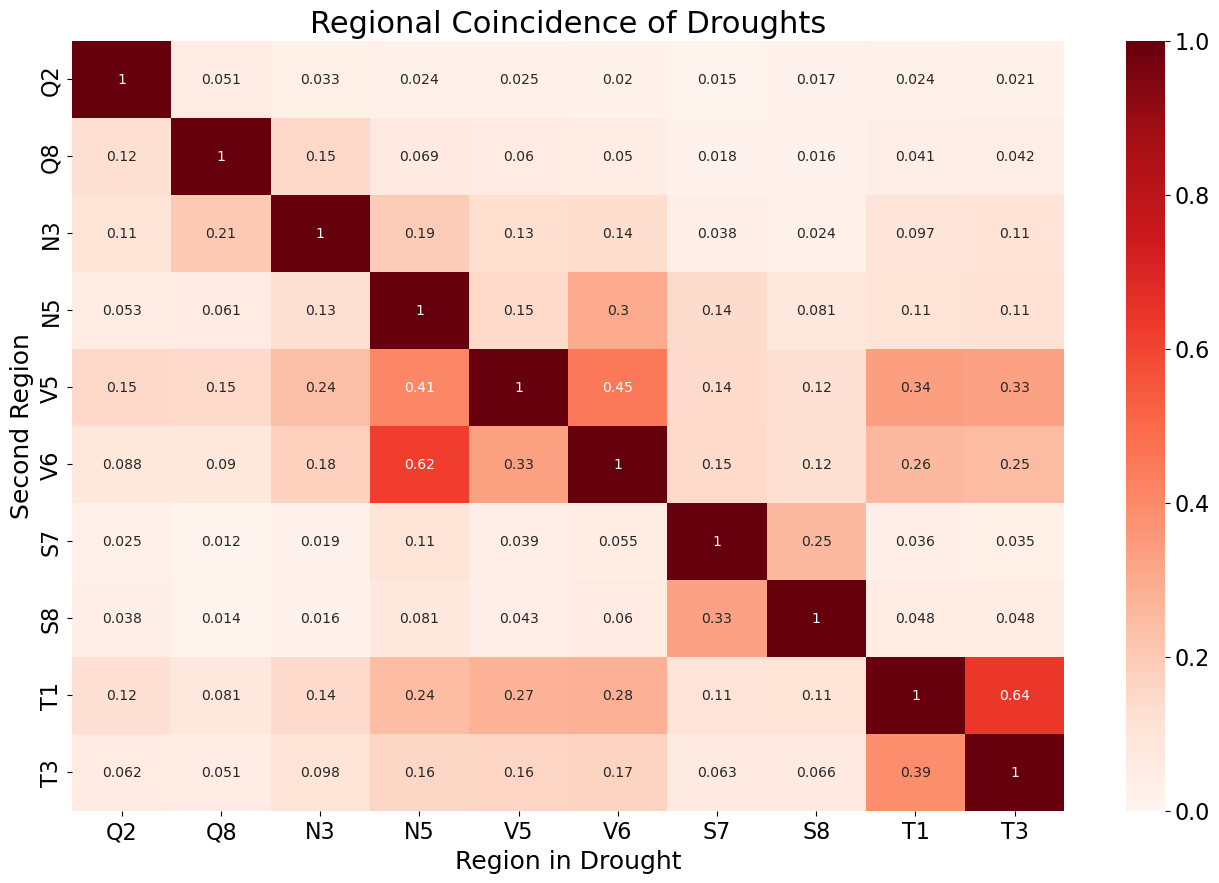

In [84]:
plt.figure(figsize=(16,10))
sns.heatmap(coincident_df, annot=True, cmap='Reds', vmin=0, vmax=1)
plt.title('Regional Coincidence of Droughts')
plt.xlabel('Region in Drought')
plt.ylabel('Second Region')
plt.show()

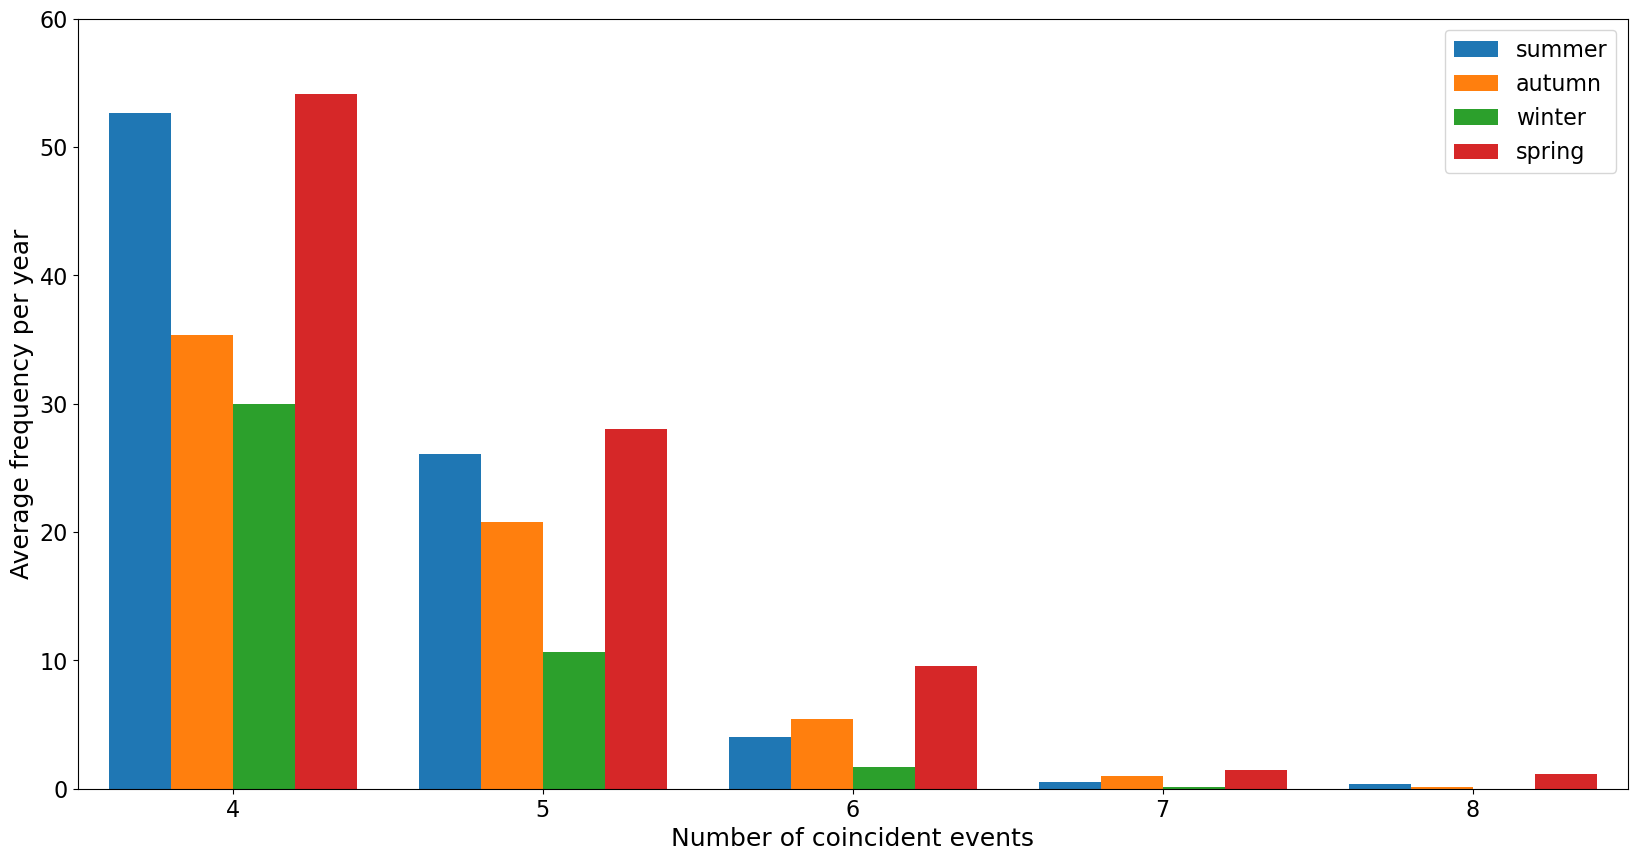

In [22]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.2
season_names = list(seasons.keys())
season_offsets = np.arange(-1.5, 2) * bar_width  # for 4 seasons

for i, season in enumerate(season_names):
    data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True).values
    num, freq = np.unique(data.data, return_counts=True)

    # Remove zero entry
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_da.time.dt.year))

    # Shift bar positions
    x_pos = num + season_offsets[i]
    ax.bar(x_pos, freq, width=bar_width, label=season)

ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 60)
ax.set_xlabel("Number of coincident events")
ax.set_ylabel("Average frequency per year")
ax.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


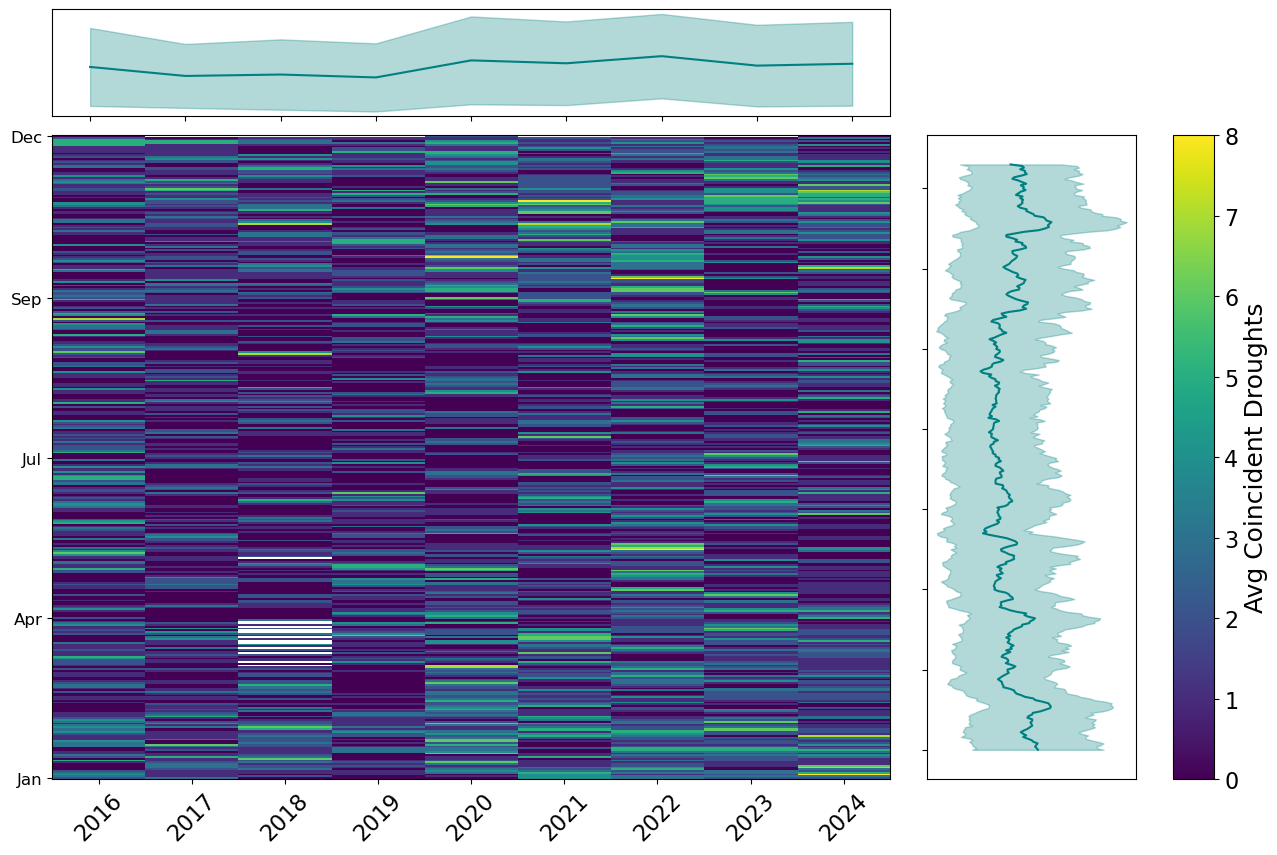

In [23]:
# Prepare data
# Prepare data
coincident_daily = coincident_da.resample(time="1D").max()
df = solar_plotting.day_year_df(coincident_daily)
# df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=8, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# X-axis: years
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

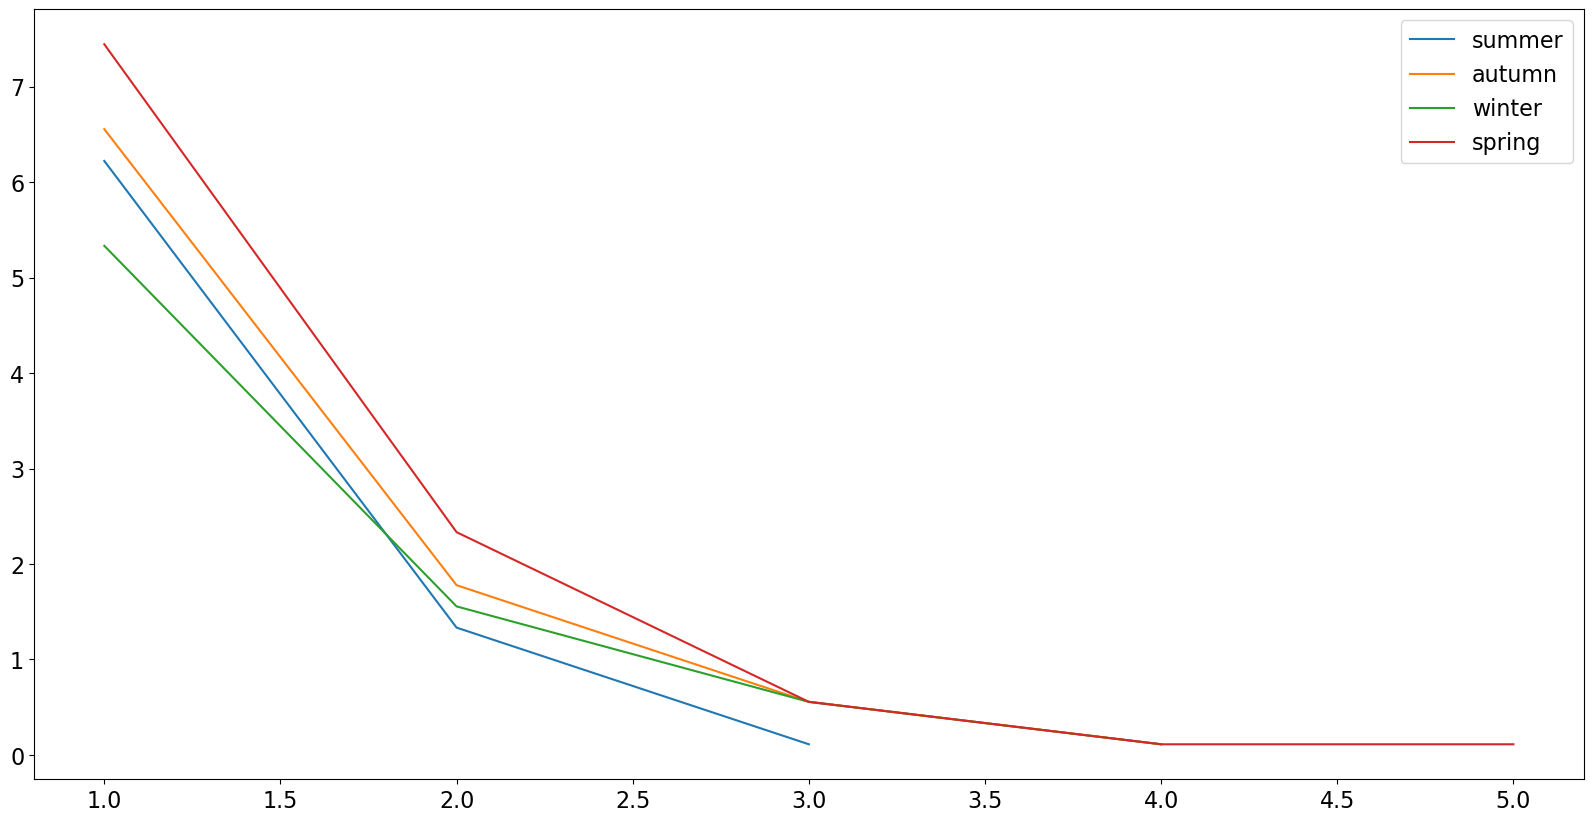

In [24]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}
fig, ax = plt.subplots(figsize=(20,10))
for season in seasons:
    data = coincident_da_daily.where(coincident_da_daily.time.dt.month.isin(seasons[season]), drop=True).data
    num, freq = np.unique(data, return_counts=True)
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_daily.time.dt.year))
    ax.plot(num, freq, label=season)
    # plt.yscale('log')
    # plt.xlim(4,8)
    # plt.ylim(0,170)
ax.legend()

In [25]:
coincident_drought_matrix

NameError: name 'coincident_drought_matrix' is not defined

In [ ]:
# Example boolean matrix: True where values are below the threshold
threshold = 0.2
coincident_drought_ds = ds_aus < threshold

# Convert to 2D for plotting: variable x time
coincident_drought_matrix = xr.concat([coincident_drought_ds[var] for var in ds_aus.data_vars], dim="variable")
coincident_drought_matrix["variable"] = list(ds_aus.data_vars)

In [ ]:
df = coincident_drought_matrix.transpose("time", "variable").to_pandas().astype(int)
df = df.drop(columns='total')

In [ ]:
df_cut = df.iloc[200:400,:]

# Stacked area plot directly (no cumulative sum needed)
df_cut.plot.area(figsize=(12, 6), cmap="tab10")
plt.title("Which series are below threshold over time")
plt.xlabel("Time")
plt.ylabel("Below-threshold indicator (stacked)")
plt.legend(title="Series", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
plt.xlim(0,1000)

# Worst Events

In [ ]:
threshold = 0.35
data = ds_aus.total.dropna(dim='time').rolling(time=100).mean()
events = xr.where(data < threshold, data, np.nan).dropna(dim='time')
np.unique(events.time.to_index().date)

In [ ]:
ds_aus.total.dropna(dim='time').rolling(time=100).mean().plot()
plt.axhline(threshold, color='r', linestyle = '--')

# Spectral Analysis

In [ ]:
def spectral_fft(da, time_res=False, clim=False, window=False):
    if time_res:
        da = da.resample(time=time_res).mean()
    if window:
        da = da.rolling(time=window, center=True, min_periods=1).mean()
    if clim:
        climatology = da.groupby("time.dayofyear").mean("time")
        da = da.groupby("time.dayofyear") - climatology
    clean = da.dropna(dim="time")
    data = (clean - clean.mean(dim='time')).values

    N = len(data)
    fft_vals = np.fft.fft(data)
    freqs = np.fft.fftfreq(N, d=1)
    
    positive = freqs > 0
    freqs_pos = freqs[positive]
    power = np.abs(fft_vals[positive])**2 / N**2

    # Normalize to match variance via Parseval
    delta_f = freqs_pos[1] - freqs_pos[0]
    power *= np.var(data) / (np.sum(power) * delta_f)

    periods = 1 / freqs_pos
    return periods, power

In [ ]:
time_res = False
clim = True
window=700

fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(16,16), sharex=True)

for i, reg in enumerate(regions):

    fft_periods, fft_power = spectral_fft(da=ds_aus[reg], time_res=time_res, clim=clim, window=window)
    # welch_periods, welch_power = solar_plotting.spectral_welch(da=ds_aus[reg], nperseg=2048, time_res=time_res, clim=clim)
    # mt_periods, mt_power = solar_plotting.spectral_multitaper(da=ds_aus[reg], NW=2.5, k=4, time_res=time_res, clim=clim)
    # mt_mask = mt_periods >= np.min(fft_periods)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    # ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    # ax[i].semilogx(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', linestyle = ':')
    ax[i].set_ylabel(reg, rotation=0, labelpad=30)
    # ax[i].set_xlim(1,100)
    # ax[i].set_ylim(0,20)
    
    fig.gca().invert_xaxis()
ax[0].legend()
plt.xlim(window)
plt.tight_layout()

In [ ]:
# Wavelet

for reg in regions:
    # daily = ds_aus[var].resample(time="1D").mean()
    clean = ds_aus[reg].dropna(dim="time")
    data = clean - clean.mean(dim="time")
    signal = data.values
    
    scales = np.arange(1, 100)
    coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='morl', sampling_period=1)
    
    # Compute power and apply log scale (add small constant to avoid log(0))
    power = np.abs(coefficients) ** 2
    log_power = np.log2(power + 1e-8)
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(power,
                    extent=[0, len(signal), scales[-1], scales[0]], #vmax = 3,
                    aspect='auto', cmap='RdYlBu_r')
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(im)
    cbar.set_label("Power")
    
    plt.xlabel("Time (samples since start)")
    plt.ylabel("Period (number of samples)")
    plt.title(reg)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()